# What is the most optimal skill to learn for Data Analyst?

### Methology
1. Group skills to determine median salary and likelihood of being in posting
2. Visualize median salary vs percent skill demand
3. Determine if certein technologies are more prevalent

In [12]:
import pandas as pd
import seaborn as sns
import ast
from datasets import load_dataset
from adjustText import adjust_text
import matplotlib.pyplot as plt

dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

#Cleaning
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)


In [17]:
job_country = 'United States'
job_title = 'Data Analyst'

df_Jobs = df[(df['job_title_short'] == job_title) & (df['job_country'] == job_country)].copy()

In [18]:
df_Jobs.dropna(subset=['salary_year_avg'], inplace = True)
df_exploded = df_Jobs.explode('job_skills')
df_exploded[['salary_year_avg', 'job_skills']].head(10)

,salary_year_avg,job_skills
109,89000.0,python
109,89000.0,r
109,89000.0,alteryx
109,89000.0,tableau
180,90250.0,excel
180,90250.0,powerpoint
410,133285.0,sql
410,133285.0,word
410,133285.0,excel
410,133285.0,visio


In [21]:
df_skills = df_exploded.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values('count', ascending = False)
df_skills = df_skills.rename(columns={'count': 'skill_count', 'median': 'median_salary'})
df_skills

,skill_count,median_salary
job_skills,,
sql,2508,91000.0
excel,1808,84392.0
python,1431,97500.0
tableau,1364,92875.0
sas,926,90000.0
...,...,...
theano,1,100000.0
typescript,1,65000.0
vmware,1,147500.0


In [48]:
total_size = len(df_Jobs)
df_skills['skill_perc'] = df_skills['skill_count'] / total_size * 100

skill_percent = 5
df_skills_high_demand = df_skills[df_skills['skill_perc'] > skill_percent]

df_skills_high_demand

,skill_count,median_salary,skill_perc
job_skills,,,
sql,2508,91000.00,57.655172
excel,1808,84392.00,41.563218
python,1431,97500.00,32.896552
tableau,1364,92875.00,31.356322
sas,926,90000.00,21.287356
r,893,92500.00,20.528736
power bi,838,90000.00,19.264368
powerpoint,462,85000.00,10.620690
word,461,81194.75,10.597701


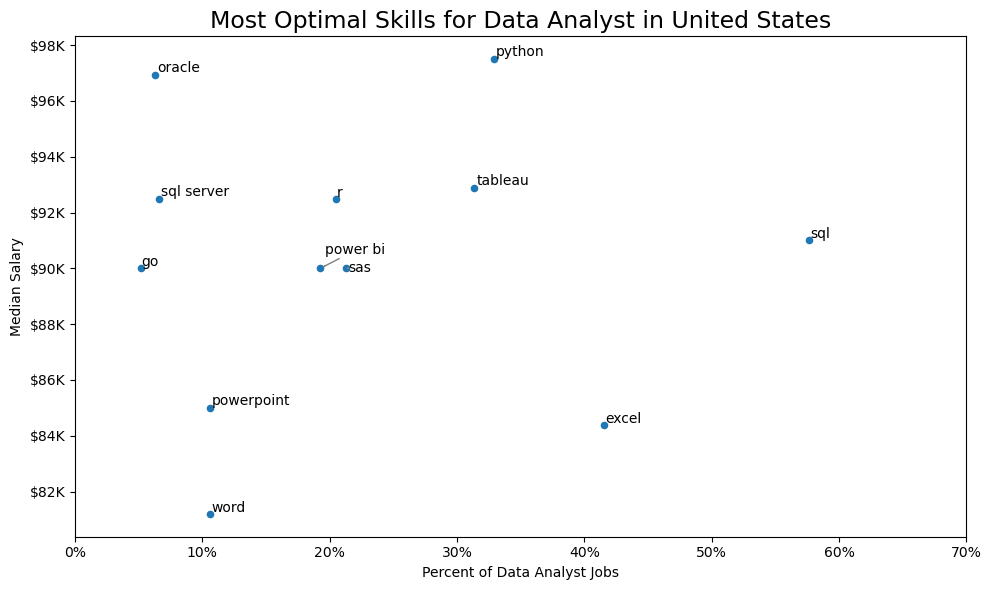

In [49]:
fig, ax = plt.subplots(figsize=(10, 6))
df_skills_high_demand.plot(kind='scatter', x = 'skill_perc', y = 'median_salary', ax=ax)
plt.xlabel('Percent of Data Analyst Jobs')
plt.ylabel('Median Salary')
plt.title(f'Most Optimal Skills for {job_title} in {job_country}', fontsize = 17)
plt.tight_layout()
plt.xlim(0, 70)

ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))
from matplotlib.ticker import PercentFormatter
ax.xaxis.set_major_formatter(PercentFormatter(decimals = 0))

texts = []
for i, txt in enumerate(df_skills_high_demand.index):
    texts.append(plt.text(df_skills_high_demand['skill_perc'].iloc[i], df_skills_high_demand['median_salary'].iloc[i], txt))
adjust_text(texts, arrowprops = dict(arrowstyle='->', color = 'gray', lw = 1))
plt.show()

In [50]:
df_technology = df['job_type_skills'].copy()

# remove duplicates
df_technology = df_technology.drop_duplicates()

# remove NaN values
df_technology = df_technology.dropna()

# combine all dictionaries into one
technology_dict = {}
for row in df_technology:
    row_dict = ast.literal_eval(row)  # convert string to dictionary
    for key, value in row_dict.items():
        if key in technology_dict:  # if key already exists in technology_dict, add value to existing value
            technology_dict[key] += value
        else:                       # if key does not exist in technology_dict, add key and value
            technology_dict[key] = value

# remove duplicates by converting values to set then back to list
for key, value in technology_dict.items():
    technology_dict[key] = list(set(value))

In [51]:
df_technology = pd.DataFrame(list(technology_dict.items()), columns=['technology', 'skills'])

df_technology = df_technology.explode('skills')

In [ ]:
# merge df_DA_skills and df_technology
df_skills_tech = df_skills.merge(df_technology, left_on='job_skills', right_on='skills')
df_skills_tech

,skill_count,median_salary,skill_perc,technology,skills
0,2508,91000.0,57.655172,programming,sql
1,1808,84392.0,41.563218,analyst_tools,excel
2,1431,97500.0,32.896552,programming,python
3,1364,92875.0,31.356322,analyst_tools,tableau
4,926,90000.0,21.287356,analyst_tools,sas
...,...,...,...,...,...
169,1,100000.0,0.022989,libraries,theano
170,1,65000.0,0.022989,programming,typescript
171,1,147500.0,0.022989,cloud,vmware
172,1,65000.0,0.022989,webframeworks,vue


In [55]:
df_skills_tech_high_demand = df_skills_tech[df_skills_tech['skill_perc'] > skill_percent]


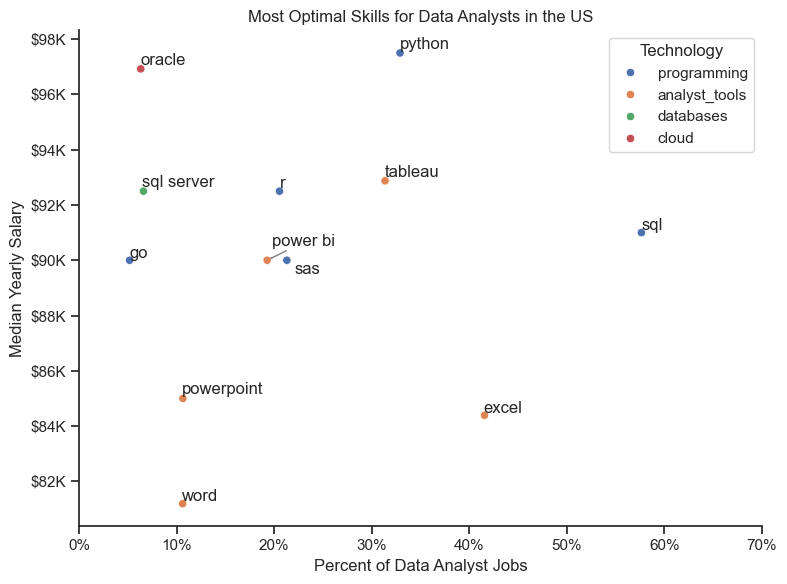

In [64]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(
    data=df_skills_tech_high_demand,
    x='skill_perc',
    y='median_salary',
    hue='technology'
)

sns.despine()
sns.set_theme(style='ticks')
# Prepare texts for adjustText
texts = []
for i, txt in enumerate(df_skills_high_demand.index):
    if txt == 'sas':
        texts.append(plt.text(df_skills_high_demand['skill_perc'].iloc[i]+1, df_skills_high_demand['median_salary'].iloc[i] - 3, txt))
    else:
        texts.append(plt.text(df_skills_high_demand['skill_perc'].iloc[i], df_skills_high_demand['median_salary'].iloc[i], txt))

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

# Set axis labels, title, and legend
plt.xlabel('Percent of Data Analyst Jobs')
plt.ylabel('Median Yearly Salary')
plt.title('Most Optimal Skills for Data Analysts in the US')
plt.legend(title='Technology')

ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))

# Adjust layout and display plot 
plt.tight_layout()
plt.xlim(0, 70)
plt.show()